# Lab 13: Krusell-Smith (1998) Model

This notebook implements the Krusell-Smith (1998) heterogeneous agent model with aggregate uncertainty.

## Learning Objectives
1. Understand the structure of heterogeneous agent models
2. Learn the Krusell-Smith algorithm for solving HA models with aggregate shocks
3. Verify the "approximate aggregation" property

## Model Overview

**Key features:**
- Continuum of agents facing idiosyncratic employment shocks
- Aggregate productivity shocks affect the entire economy
- Incomplete markets: agents can only save in capital (no insurance)
- Bounded rationality: agents forecast aggregate capital using a simple rule

## 1. Code Structure Overview

The implementation is organized into the following modules:

```
Lab_13_HA_Model/
├── config.py      # Parameters and grid specifications
├── shock.py       # Shock process simulation
├── household.py   # Individual household problem
├── simulation.py  # Aggregate economy simulation
└── equilibrium.py # Main KS algorithm
```

### Module Responsibilities

| Module | Purpose | Key Functions |
|--------|---------|---------------|
| `config.py` | Model parameters, grids, price functions | `compute_prices()`, `compute_budget()` |
| `shock.py` | Markov chain for (Z, ε) shocks | `ShockSimulator.simulate()` |
| `household.py` | Solve individual optimization | `solve_household_problem()` |
| `simulation.py` | Simulate aggregate economy | `simulate_economy()`, `update_PLM_coefficients()` |
| `equilibrium.py` | Main KS iteration | `solve_krusell_smith()` |

## 2. The Krusell-Smith Algorithm

### The Challenge

In a heterogeneous agent model with aggregate shocks:
- Agents need to forecast future prices to make optimal decisions
- Prices depend on aggregate capital $K$
- Aggregate capital depends on the **entire wealth distribution** $\mu$
- The distribution $\mu$ is infinite-dimensional!

### The Solution: Bounded Rationality

Krusell & Smith's insight: Agents use a simple forecasting rule (PLM):

$$\log K' = B_{Z,0} + B_{Z,1} \cdot \log K$$

where $B$ depends on the aggregate state $Z \in \{\text{bad}, \text{good}\}$.

### Algorithm Steps

```
┌─────────────────────────────────────────────────────────────┐
│  1. Initialize PLM coefficients B                          │
└─────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────┐
│  2. Solve household problem given B                        │
│     → Policy function k'(k, K, Z, ε)                       │
└─────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────┐
│  3. Simulate economy for T periods                         │
│     → Time series {K_t}                                    │
└─────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────┐
│  4. Update B via OLS regression                            │
│     log(K') = B₀ + B₁·log(K)                               │
└─────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────────────────────────────┐
│  5. Check convergence: ||B_new - B_old|| < ε ?             │
│     If No → Go to Step 2                                   │
│     If Yes → Done!                                         │
└─────────────────────────────────────────────────────────────┘
```

## 3. Implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Import our modules
from config import *
from shock import ShockSimulator
from equilibrium import solve_krusell_smith, verify_approximate_aggregation

### 3.1 Model Parameters

Let's examine the key parameters:

In [3]:
print("=" * 50)
print("Model Parameters")
print("=" * 50)
print(f"Discount factor (β):     {beta}")
print(f"Risk aversion (γ):       {gamma}")
print(f"Capital share (α):       {alpha}")
print(f"Depreciation (δ):        {delta}")
print(f"UI replacement (μ):      {mu}")
print(f"\nSteady-state capital:    {k_ss:.2f}")
print(f"\nGrid sizes:")
print(f"  Individual capital:    {k_ngrid} points in [{k_min}, {k_max}]")
print(f"  Aggregate capital:     {K_ngrid} points in [{K_min}, {K_max}]")
print(f"  Aggregate shock:       {Z_ngrid} states")
print(f"  Employment:            {epsilon_ngrid} states")
print(f"\nSimulation:")
print(f"  Number of agents:      {N_agents:,}")
print(f"  Simulation periods:    {T_sim}")
print(f"  Burn-in periods:       {T_burn}")

Model Parameters
Discount factor (β):     0.99
Risk aversion (γ):       1.0
Capital share (α):       0.36
Depreciation (δ):        0.025
UI replacement (μ):      0.15

Steady-state capital:    37.99

Grid sizes:
  Individual capital:    100 points in [0.0, 500.0]
  Aggregate capital:     4 points in [30.0, 50.0]
  Aggregate shock:       2 states
  Employment:            2 states

Simulation:
  Number of agents:      10,000
  Simulation periods:    1100
  Burn-in periods:       100


### 3.2 Shock Process

The model has two types of shocks:
1. **Aggregate shock** $Z \in \{Z_{bad}, Z_{good}\}$: Affects productivity
2. **Idiosyncratic shock** $\epsilon \in \{0, 1\}$: Employment status

These follow a joint Markov process.

In [4]:
# Create shock simulator
shock_sim = ShockSimulator(Pi)

print("Joint Transition Matrix (4x4):")
print("States: [bad-unemp, bad-emp, good-unemp, good-emp]")
print(Pi.round(4))

print(f"\nAggregate Transition Matrix:")
print(f"  P(bad→bad):   {shock_sim.Pi_Z[0,0]:.4f}")
print(f"  P(bad→good):  {shock_sim.Pi_Z[0,1]:.4f}")
print(f"  P(good→bad):  {shock_sim.Pi_Z[1,0]:.4f}")
print(f"  P(good→good): {shock_sim.Pi_Z[1,1]:.4f}")

print(f"\nUnemployment rates:")
print(f"  Bad state:    {shock_sim.ur_bad*100:.1f}%")
print(f"  Good state:   {shock_sim.ur_good*100:.1f}%")

Joint Transition Matrix (4x4):
States: [bad-unemp, bad-emp, good-unemp, good-emp]
[[0.525  0.35   0.0312 0.0938]
 [0.0389 0.8361 0.0021 0.1229]
 [0.0938 0.0312 0.2917 0.5833]
 [0.0091 0.1159 0.0243 0.8507]]

Aggregate Transition Matrix:
  P(bad→bad):   0.8750
  P(bad→good):  0.1250
  P(good→bad):  0.1250
  P(good→good): 0.8750

Unemployment rates:
  Bad state:    10.0%
  Good state:   4.0%


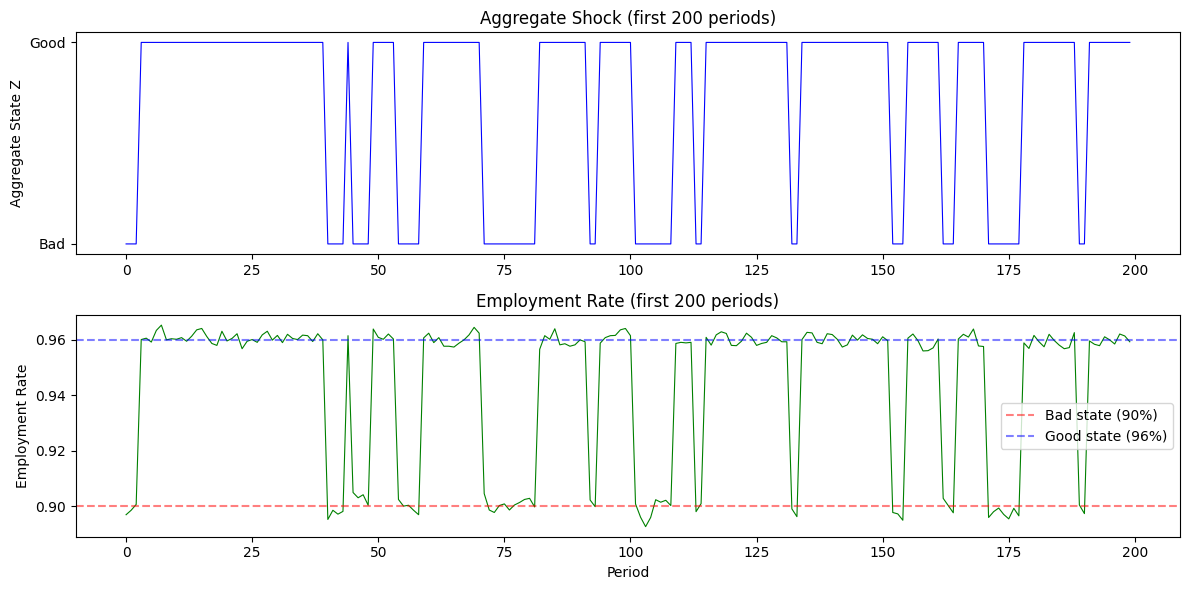

In [5]:
# Simulate shocks
Z_history, eps_history = shock_sim.simulate(T_sim, N_agents, seed=42)

# Plot aggregate shock
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].plot(Z_history[:200], 'b-', linewidth=0.8)
axes[0].set_ylabel('Aggregate State Z')
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['Bad', 'Good'])
axes[0].set_title('Aggregate Shock (first 200 periods)')

# Employment rate over time
emp_rate = eps_history.mean(axis=1)
axes[1].plot(emp_rate[:200], 'g-', linewidth=0.8)
axes[1].axhline(1 - ur_bad, color='r', linestyle='--', alpha=0.5, label=f'Bad state ({(1-ur_bad)*100:.0f}%)')
axes[1].axhline(1 - ur_good, color='b', linestyle='--', alpha=0.5, label=f'Good state ({(1-ur_good)*100:.0f}%)')
axes[1].set_ylabel('Employment Rate')
axes[1].set_xlabel('Period')
axes[1].set_title('Employment Rate (first 200 periods)')
axes[1].legend()

plt.tight_layout()
plt.show()

### 3.3 Solve the Model

Now we run the full Krusell-Smith algorithm:

In [6]:
# Solve the model
results = solve_krusell_smith(verbose=True, seed=42)

Krusell-Smith Algorithm

Generating shock sequences...

--- Outer Iteration 1 ---

Step 1: Solving household problem...
  Policy iteration 0: diff = 6.53e+00, euler = 4.67e-33
  Policy iteration 100: diff = 7.37e-02, euler = 4.42e-33
  Policy iteration 200: diff = 1.80e-02, euler = 4.69e-33
  Policy iteration 300: diff = 6.58e-03, euler = 4.64e-33
  Policy iteration 400: diff = 2.60e-03, euler = 4.53e-33
  Policy iteration 500: diff = 1.08e-03, euler = 4.52e-33
  Policy iteration 600: diff = 4.57e-04, euler = 4.77e-33
  Policy iteration 700: diff = 1.98e-04, euler = 4.33e-33
  Policy iteration 800: diff = 8.55e-05, euler = 5.71e-33
  Policy iteration 900: diff = 3.70e-05, euler = 4.95e-33
  Policy iteration 1000: diff = 1.61e-05, euler = 5.05e-33
  Policy iteration 1100: diff = 6.98e-06, euler = 4.77e-33
  Policy iteration 1200: diff = 3.03e-06, euler = 5.06e-33
  Policy iteration 1300: diff = 1.24e-06, euler = 5.34e-33
  Policy iteration 1400: diff = 3.58e-07, euler = 5.21e-33
  Polic

### 3.4 Verify Approximate Aggregation

Krusell & Smith's key finding: The first moment (mean capital) is sufficient to forecast future aggregate capital with $R^2 > 0.9999$.

In [7]:
# Verify approximate aggregation
stats = verify_approximate_aggregation(results, verbose=True)


Approximate Aggregation Verification
R² (bad state):  0.999957
R² (good state): 0.999974
Max % forecast error: 0.4776%

Krusell & Smith finding: R² > 0.9999
✓ Approximate aggregation holds!


## 4. Visualize Results

### 4.1 Aggregate Capital Dynamics: PLM vs ALM

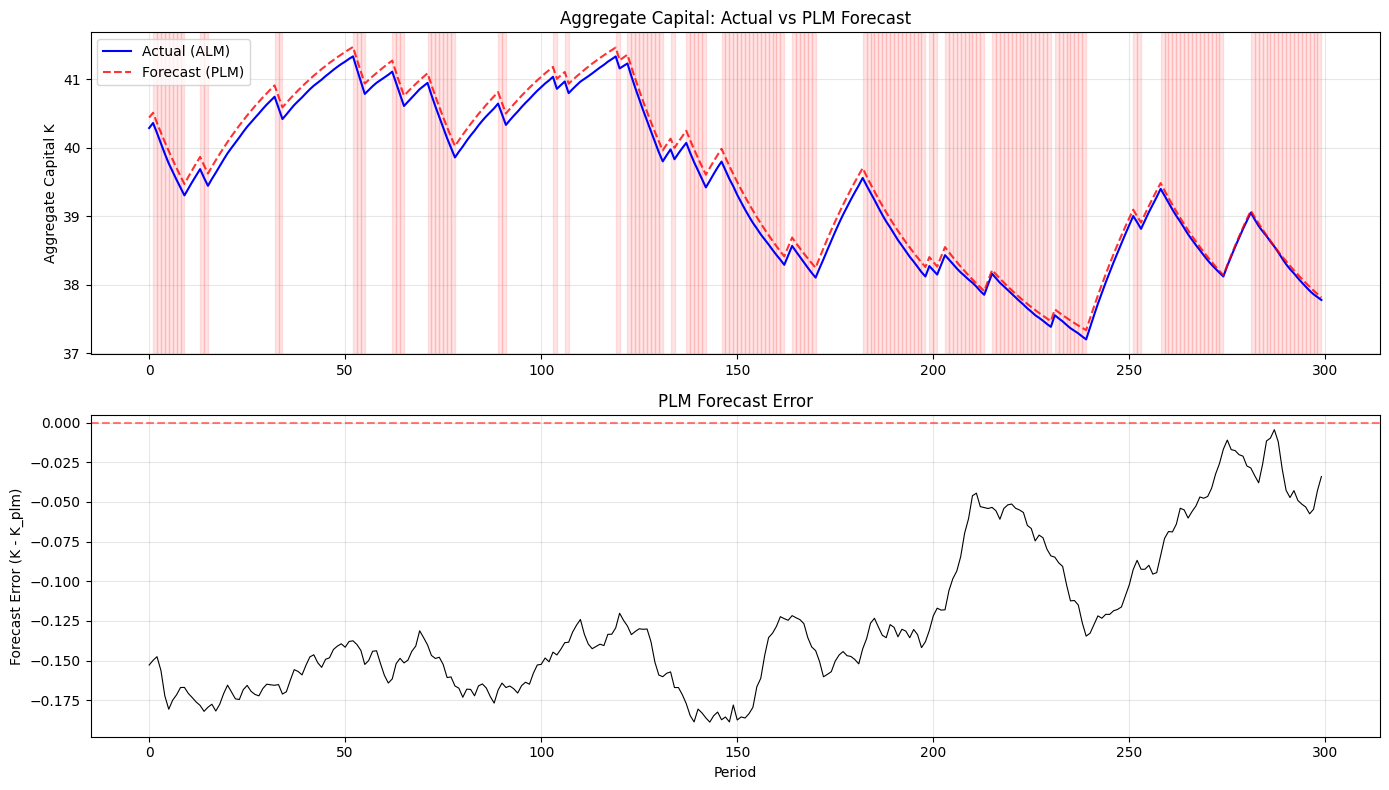


Max absolute forecast error: 0.1888
Mean absolute forecast error: 0.0784


In [8]:
K_history = results['K_history']
K_plm = results['K_plm']
Z_history = results['Z_history']

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot K time series
t_start, t_end = 100, 400
axes[0].plot(K_history[t_start:t_end], 'b-', label='Actual (ALM)', linewidth=1.5)
axes[0].plot(K_plm[t_start:t_end], 'r--', label='Forecast (PLM)', linewidth=1.5, alpha=0.8)
axes[0].set_ylabel('Aggregate Capital K')
axes[0].set_title('Aggregate Capital: Actual vs PLM Forecast')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Shade by aggregate state
for t in range(t_start, t_end-1):
    if Z_history[t] == 0:  # Bad state
        axes[0].axvspan(t-t_start, t-t_start+1, alpha=0.1, color='red')

# Forecast error
axes[1].plot(K_history[t_start:t_end] - K_plm[t_start:t_end], 'k-', linewidth=0.8)
axes[1].axhline(0, color='r', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Forecast Error (K - K_plm)')
axes[1].set_xlabel('Period')
axes[1].set_title('PLM Forecast Error')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMax absolute forecast error: {np.max(np.abs(K_history - K_plm)):.4f}")
print(f"Mean absolute forecast error: {np.mean(np.abs(K_history - K_plm)):.4f}")

### 4.2 Policy Function

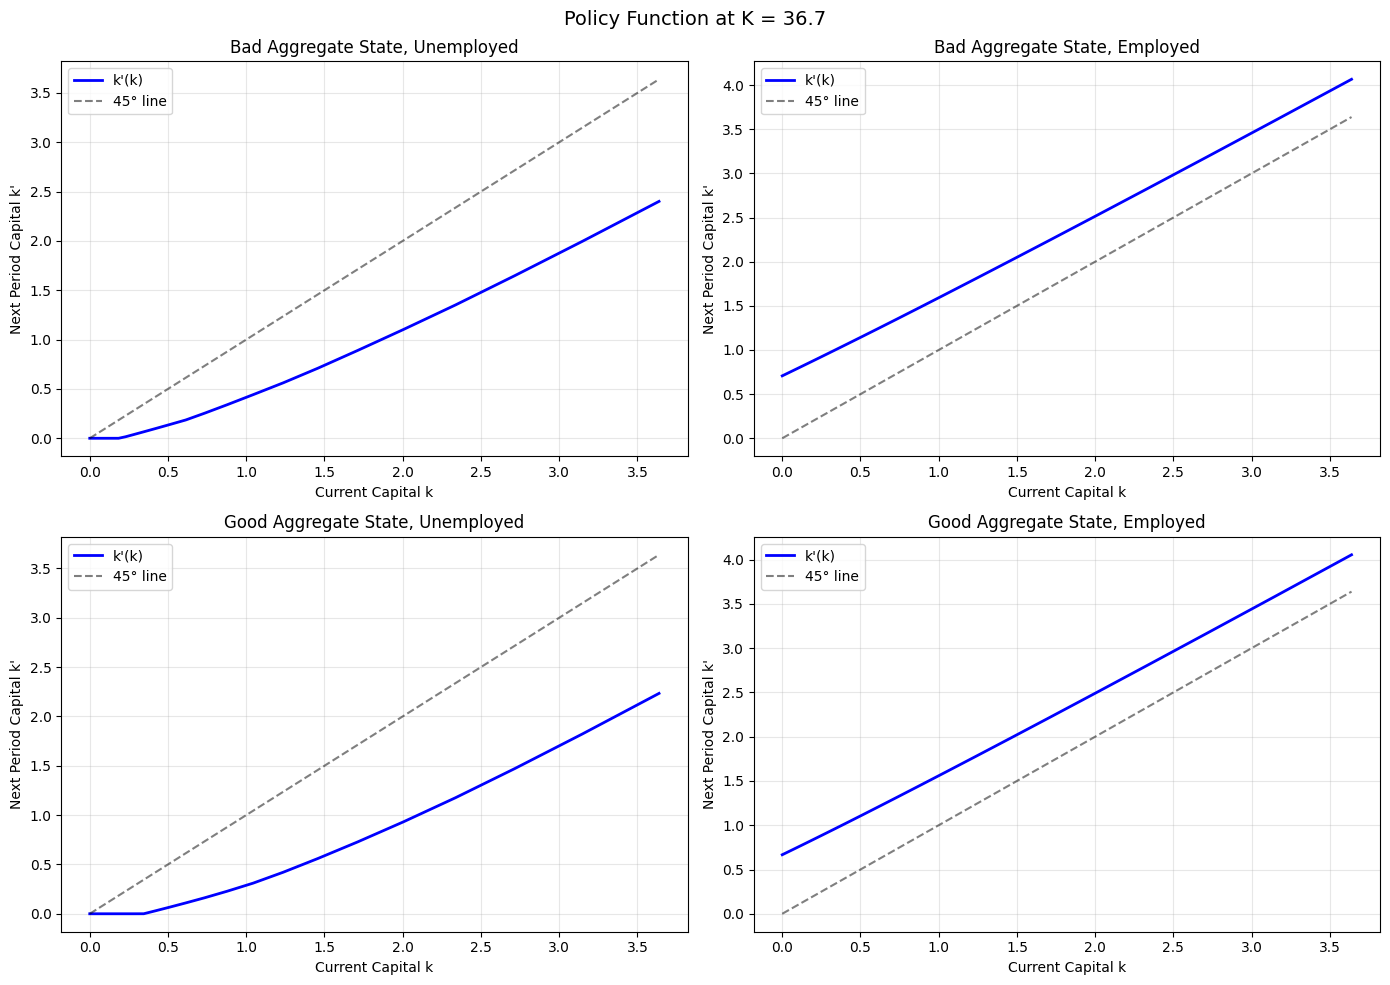

In [9]:
policy = results['policy']

# Plot policy for different states
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Choose K value (median of simulated K)
K_median = np.median(K_history)
K_idx_plot = np.argmin(np.abs(K_grid - K_median))

k_plot = k_grid[:50]  # Focus on lower k values

for i, (Z_name, Z_val) in enumerate([('Bad', 0), ('Good', 1)]):
    for j, (eps_name, eps_val) in enumerate([('Unemployed', 0), ('Employed', 1)]):
        ax = axes[i, j]
        
        # Policy function
        kp = policy[:50, K_idx_plot, Z_val, eps_val]
        
        ax.plot(k_plot, kp, 'b-', linewidth=2, label="k'(k)")
        ax.plot(k_plot, k_plot, 'k--', alpha=0.5, label='45° line')
        ax.set_xlabel('Current Capital k')
        ax.set_ylabel("Next Period Capital k'")
        ax.set_title(f'{Z_name} Aggregate State, {eps_name}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle(f'Policy Function at K = {K_grid[K_idx_plot]:.1f}', fontsize=14)
plt.tight_layout()
plt.show()

### 4.3 Wealth Distribution

/var/folders/q7/lwn2vx9138g3s5z2vnwb01z80000gn/T/ipykernel_70147/192631743.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(k_cumsum, pop_share)


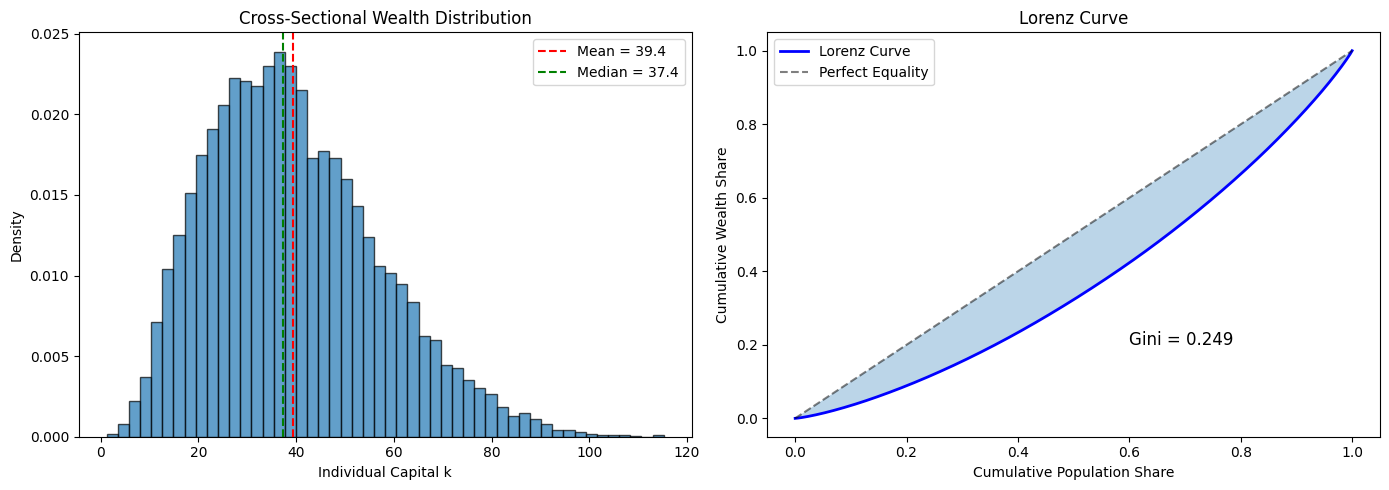


Wealth Distribution Statistics:
  Mean:   39.45
  Median: 37.37
  Std:    17.51
  Gini:   0.249


In [10]:
k_distribution = results['k_distribution']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(k_distribution, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(k_distribution), color='r', linestyle='--', 
                label=f'Mean = {np.mean(k_distribution):.1f}')
axes[0].axvline(np.median(k_distribution), color='g', linestyle='--',
                label=f'Median = {np.median(k_distribution):.1f}')
axes[0].set_xlabel('Individual Capital k')
axes[0].set_ylabel('Density')
axes[0].set_title('Cross-Sectional Wealth Distribution')
axes[0].legend()

# Lorenz curve
k_sorted = np.sort(k_distribution)
k_cumsum = np.cumsum(k_sorted) / np.sum(k_sorted)
pop_share = np.arange(1, len(k_sorted)+1) / len(k_sorted)

axes[1].plot(pop_share, k_cumsum, 'b-', linewidth=2, label='Lorenz Curve')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Equality')
axes[1].fill_between(pop_share, k_cumsum, pop_share, alpha=0.3)
axes[1].set_xlabel('Cumulative Population Share')
axes[1].set_ylabel('Cumulative Wealth Share')
axes[1].set_title('Lorenz Curve')
axes[1].legend()

# Compute Gini coefficient
gini = 1 - 2 * np.trapz(k_cumsum, pop_share)
axes[1].text(0.6, 0.2, f'Gini = {gini:.3f}', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nWealth Distribution Statistics:")
print(f"  Mean:   {np.mean(k_distribution):.2f}")
print(f"  Median: {np.median(k_distribution):.2f}")
print(f"  Std:    {np.std(k_distribution):.2f}")
print(f"  Gini:   {gini:.3f}")